In this script implements a Generative Adversarial Network (GAN) in TensorFlow -following a StyleGAN architecture - tailored for generating anime-style images representing the style of the Dragon Ball Z characters. It encompasses the following key components:

- Setup and Dependencies: The code starts by mounting Google Drive for data access and installing necessary dependencies, including TensorFlow and TensorFlow Addons.

- Function Definitions: It includes several functions for loading and preprocessing images, generating new images, and building the GAN's architecture. This includes the generator and discriminator models, which are central to the GAN's operation.

- Model Training: The script outlines the process of training the GAN, including defining loss functions, optimizers, and a training loop. This section details the steps taken to train the model on the DBZ dataset.

- Image Generation and Testing: Post-training, the script demonstrates how to use the trained GAN to generate new anime-style images from a set of test images, showcasing the model's ability to create stylized renditions of the input.

#Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/CIS_5810_Final_Project_Folder

/content/drive/MyDrive/CIS_5810_Final_Project_Folder


In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.4 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from IPython.display import display, clear_output


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#Define Functions

In [ ]:
noise_dim = 100  # Dimensionality of the noise vector
OUTPUT_CHANNELS = 3

In [1]:
def generate_and_save_images(model, epoch, test_noise, test_images):
  # Generates images using the GAN model for given noise and test images
  # 'epoch' is used to track the progress and name the output files

    predictions = model([test_images, test_noise], training=False)

    fig = plt.figure(figsize=(4, 4))


    # Iterate through each prediction and plot it
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :] * 127.5 + 127.5) / 255.0)
        plt.axis('off')

    # Save the plotted images as a PNG file, naming it with the current epoch number
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


In [ ]:
def load_images_from_folder(base_folder, img_height, img_width):
    # Loads images from a specified folder, resizing them to a given height and width
    images = []
    for character_folder in os.listdir(base_folder):
        character_folder_path = os.path.join(base_folder, character_folder)

        # Check if the path is a directory to proceed with image loading
        if os.path.isdir(character_folder_path):
            for filename in os.listdir(character_folder_path):
                img_path = os.path.join(character_folder_path, filename)
                try:
                    # Load and convert each image to an array
                    img = load_img(img_path, target_size=(img_height, img_width))
                    images.append(img_to_array(img))

                except Exception as e:
                    # Handle exceptions during image loading
                    print(f"Could not load image: {img_path}. Error: {e}")

    # Return the list of images as a numpy array
    return np.array(images)

# Set image dimensions
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Load dataset
dbz_dataset_path = '/content/drive/MyDrive/CIS_5810_Final_Project_Folder/DBZ'
dbz_images = load_images_from_folder(dbz_dataset_path, IMG_HEIGHT, IMG_WIDTH)
dbz_images = (dbz_images - 127.5) / 127.5  # Normalize images to [-1, 1]

In [ ]:
def noise_(num, filter, noise):
    # Creates a noise layer to be used in the generator
    # 'num' and 'filter' define the dimensions and depth of the noise layer
    noise_layer = tf.keras.layers.Dense(num*num*filter)(noise)

    # Reshapes the noise layer to the specified dimensions
    reshape_noise = tf.keras.layers.Reshape((num, num, filter))(noise_layer)

    return reshape_noise

def downsample(filters, size, stride, apply_batchnorm=True):
    # Creates a downsampling layer for the neural network
    # 'filters' specify the depth, 'size' the kernel size, and 'stride' the stride
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()

    # Adds a Conv2D layer with specified parameters
    result.add(
              tf.keras.layers.Conv2D(
                  filters,
                  size,
                  strides=stride,
                  padding='same',
                  kernel_initializer=initializer,
                  use_bias=False)
    )

    # Optionally applies instance normalization

    if apply_batchnorm:
        result.add(tfa.layers.InstanceNormalization())

    # Adds a LeakyReLU layer for non-linearity.

    result.add(tf.keras.layers.LeakyReLU(0.4))

    return result

def upsample(filters, size, stride):
    # Creates an upsampling layer for the neural network
    # Similar to 'downsample', but uses 'Conv2DTranspose' for upsampling
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    layer = tf.keras.layers.Conv2DTranspose(
            filters,
            size,
            strides=stride,
            padding='same',
            kernel_initializer=initializer,
            use_bias=False)

    result.add(
        layer
    )
    return result

In [ ]:
def Generator():
    # Defines the generator model for the GAN
    # Takes an image input and a noise vector as inputs
    input_encoder = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH,3])
    input_generator = tf.keras.layers.Input(shape=[noise_dim, ])
    initializer = tf.random_normal_initializer(0., 0.02)

    # Create a series of downsampling layers
    down_stack = [
        downsample(64, 3, 2,False),
        downsample(128, 3, 2),
        downsample(256, 3, 2,False),
        downsample(512, 3, 2,),
        downsample(512, 3, 2,False),
        downsample(512, 3, 2,),
     ]
    x = input_encoder
    skips = []
    # Apply downsampling and store skip connections
    for down in down_stack:
        x = down(x)
        skips.append(x)

    # Skip connection for the U-Net architecture
    skips = reversed(skips[:-1])
    # Processing the noise input
    gen_layer = tf.keras.layers.Dense(4*4*512)(input_generator)
    gen_layer = tf.keras.layers.BatchNormalization()(gen_layer)
    gen_layer = tf.keras.layers.LeakyReLU(0.4)(gen_layer)

    reshape = tf.keras.layers.Reshape((4, 4, 512))(gen_layer)
    x = reshape
    # Create a series of upsampling layers
    up_stack = [
              upsample(512, 3, 2, ),
              upsample(512, 3, 2, ),
              upsample(256, 3, 2, ),
              upsample(128, 3, 2, ),
              upsample(64, 3, 2, ),

   ]

    # Final layer of the generator
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,
                                      strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      activation='tanh')
    filters = [512,512,256,128,64]
    ndim = [8,16,32,64,128]
    # Concatenate noise and skip connections at each upsampling stage
    for up, skip, dim, filt in zip(up_stack, skips, ndim, filters):
        x = up(x)
        n = noise_(dim, filt, input_generator)
        x = tf.keras.layers.concatenate([n, x])
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(0.4)(x)

        x = tf.keras.layers.concatenate([x, skip])

    x = last(x)
    return tf.keras.Model(inputs=[input_encoder,input_generator], outputs=x)

In [ ]:
def Discriminator():
    # Defines the discriminator model for the GAN
    initializer = tf.random_normal_initializer(0., 0.02)
    input_ = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='input_image')
    # Downsampling layers
    down1 = downsample(64, 3, 2,False)(input_)
    down2 = downsample(128, 3, 2)(down1)

    # Convolutional layers with zero padding and batch normalization
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2)
    conv = tf.keras.layers.Conv2D(256, 3, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv) #Itfa.layers.InstanceNormalization()

    leaky_relu = tf.keras.layers.LeakyReLU(0.4)(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

    # Final layer of the discriminator
    last = tf.keras.layers.Conv2D(1, 3, strides=1,
                                kernel_initializer=initializer,
                                )(zero_pad2)
    return tf.keras.Model(inputs=input_, outputs=last)

In [ ]:
# Define the Generator and Discriminator
generator = Generator()
discriminator = Discriminator()


#Training

In [ ]:
import time
import IPython.display as display


In [ ]:
# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(generated_output):
    return cross_entropy(tf.ones_like(generated_output), generated_output)

def discriminator_loss(real_output, generated_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    generated_loss = cross_entropy(tf.zeros_like(generated_output), generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


# `train_step` function
@tf.function
def train_step(real_images, noise):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images
        generated_images = generator([real_images, noise], training=True)

        # Discriminator's prediction on real and fake images
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculate the generator and discriminator loss
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Compute the gradients for generator and discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply the gradients to the optimizer
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



"""#Training Loop"""

# Set training parameters
EPOCHS = 5 ##########
BATCH_SIZE = 2
num_examples_to_generate = 16  # Number of examples to generate from the generator to visualize progress

# We will reuse this seed overtime to visualize progress in the animated GIF
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Convert dbz_images to a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(dbz_images).shuffle(1000).batch(BATCH_SIZE)


# Training loop
for epoch in range(EPOCHS):
    start = time.time()

    # Assuming dbz_images is a dataset of images
    for real_images in train_dataset:
        # Generate a batch of noise vectors
        noise = tf.random.normal([BATCH_SIZE, noise_dim])
        train_step(real_images, noise)

    # Produce images for the GIF as we go
    clear_output(wait=True)

    # Generate and save images after every epoch
    test_noise = tf.random.normal([num_examples_to_generate, noise_dim])
    #generate_and_save_images(generator, epoch + 1, test_noise)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


display.clear_output(wait=True)







Time for epoch 5 is 95.34911847114563 sec


#Test on Sample Image

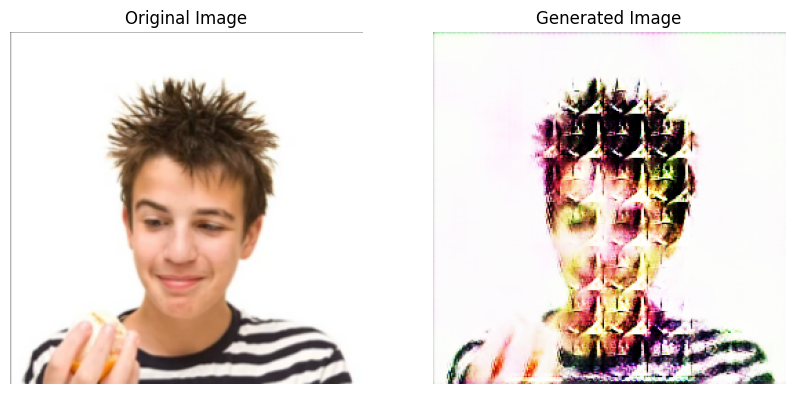

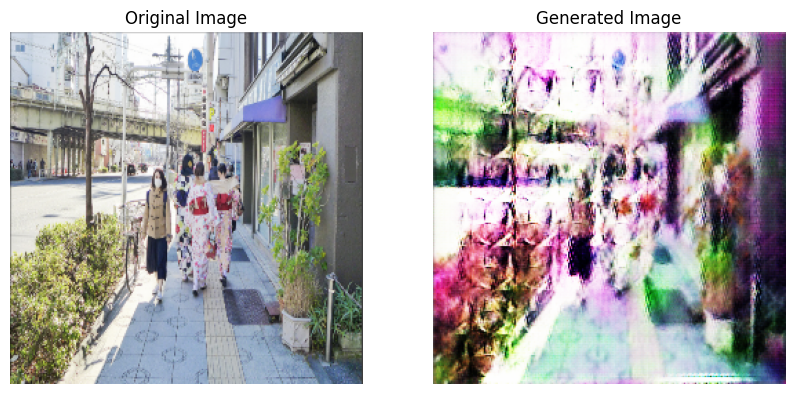

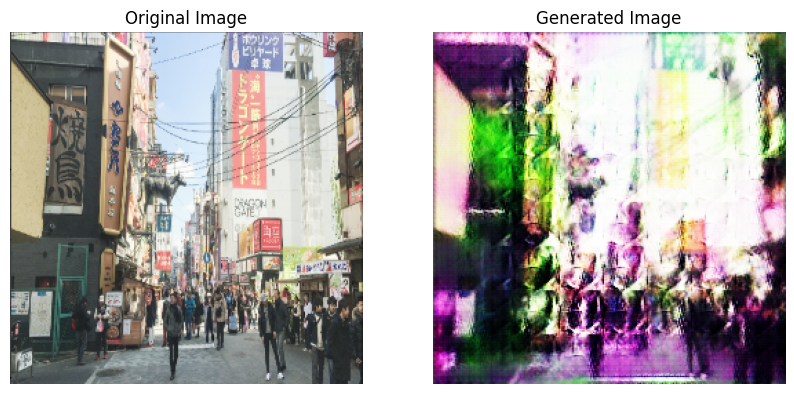

In [ ]:
import glob

# Function to preprocess the image
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = (img - 127.5) / 127.5  # Normalize to [-1, 1]
    return img

# Folder containing the test images
test_image_folder = '/content/drive/MyDrive/CIS_5810_Final_Project_Folder/DBZ_outputs_3'
test_image_paths = glob.glob(test_image_folder + '/*.png')

# Process and generate images for each test image
for image_path in test_image_paths:
    # Load and preprocess the test image
    test_image = preprocess_image(image_path)
    test_image = tf.expand_dims(test_image, 0)  # Add batch dimension

    # Generate images from the test image
    noise = tf.random.normal([1, noise_dim])
    generated_image = generator([test_image, noise], training=False)

    # Convert the generated image to the [0, 255] range
    generated_image = (generated_image * 0.5 + 0.5) * 255
    generated_image = tf.cast(generated_image, tf.uint8)

    # Visualize the result
    plt.figure(figsize=(10, 5))

    # Display original image
    original_image = tf.io.read_file(image_path)
    original_image = tf.image.decode_png(original_image, channels=3)
    original_image = tf.image.resize(original_image, [IMG_HEIGHT, IMG_WIDTH])
    plt.subplot(1, 2, 1)
    plt.imshow(original_image / 255.0)
    plt.title('Original Image')
    plt.axis('off')

    # Display generated image
    plt.subplot(1, 2, 2)
    plt.imshow(generated_image[0])
    plt.title('Generated Image')
    plt.axis('off')

    plt.show()
